# Sentiment Analysis: FastText + Classical ML

End-to-end sentiment classification using FastText embeddings with XGBoost and Random Forest.

**Pipeline:** Data loading (IMDB) → Preprocessing → FastText embeddings → Training → Evaluation

## 1. Setup & Install Dependencies

In [1]:
!pip install -q fasttext xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import xgboost as xgb
import fasttext
import re

#2d projection
from sklearn.manifold import TSNE

# for dataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All libraries ready")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✓ All libraries ready


## 2. Load IMDB Dataset

In [18]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)

word_index = imdb.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"

def decode_review(sequence):
    return " ".join([index_word.get(i, "<UNK>") for i in sequence])

X_train_text = [decode_review(x) for x in X_train]
X_test_text = [decode_review(x) for x in X_test]

df = pd.DataFrame(X_train_text, columns=['review'])
df['sentiment'] = y_train

,review,sentiment
0,<START> this film was just brilliant casting l...,1
1,<START> big hair big boobs bad music and a gia...,0
2,<START> this has to be one of the worst films ...,0
3,<START> the scots excel at storytelling the tr...,1
4,<START> worst mistake of my life br br i picke...,0
...,...,...
24995,<START> this is a racist movie but worthy of s...,1
24996,<START> bela lugosi plays a doctor who will do...,0
24997,<START> in a far away galaxy is a planet calle...,0
24998,<START> six degrees had me hooked i looked for...,1


### Data Visualization

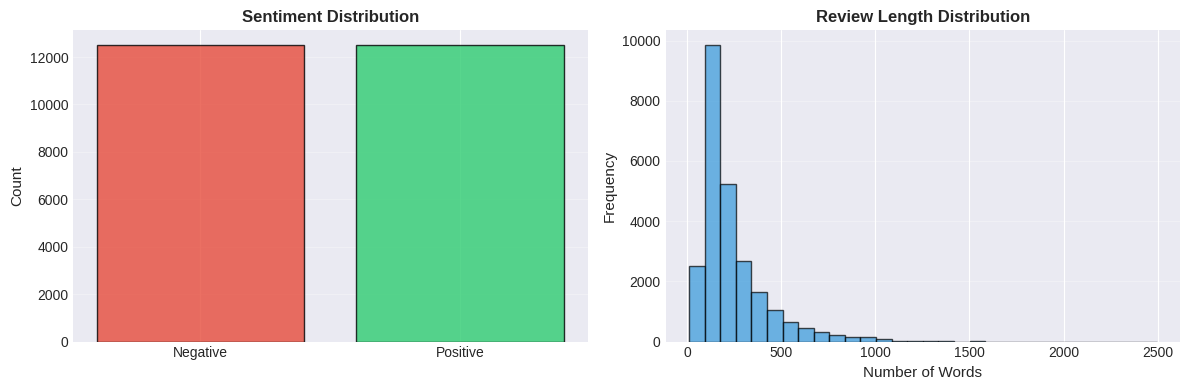

Review length statistics:
count    25000.000000
mean       238.710480
std        176.492037
min         11.000000
25%        130.000000
50%        178.000000
75%        291.000000
max       2494.000000
Name: review_length, dtype: float64


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sentiment_counts = df['sentiment'].value_counts().sort_index()
axes[0].bar(['Negative', 'Positive'], sentiment_counts.values, color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

df['review_length'] = df['review'].str.split().str.len()
axes[1].hist(df['review_length'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Words', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Review Length Distribution', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Review length statistics:")
print(df['review_length'].describe())

## 3. Text Preprocessing

In [3]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

X_train_tokens = [clean_text(x) for x in X_train_text]
X_test_tokens = [clean_text(x) for x in X_test_text]


## 4. FastText Embeddings

In [ ]:
! pip install gensim
from gensim.models import FastText

fasttext_model = FastText(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # Skip-gram
)


print(f"✓ Training file created")

In [7]:
def sentence_vector(tokens, model, vector_size=100):
    vectors = [
        model.wv[word] for word in tokens if word in model.wv
    ]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

X_train_vec = np.array([
    sentence_vector(tokens, fasttext_model)
    for tokens in X_train_tokens
])

X_test_vec = np.array([
    sentence_vector(tokens, fasttext_model)
    for tokens in X_test_tokens
])




## 6. Model Training

In [10]:
print("Training XGBoost...")
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method="hist"
)

xgb_model.fit(X_train_vec, y_train)
xgb_preds = xgb_model.predict(X_test_vec)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))




Training XGBoost...
XGBoost Accuracy: 0.85316


In [9]:
print("Training Random Forest...")

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_vec, y_train)
rf_preds = rf_model.predict(X_test_vec)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))




Training Random Forest...
Random Forest Accuracy: 0.82696
✓ Random Forest trained!


## 7. Model Evaluation

In [12]:
def evaluate_model(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }
    return metrics

results = []
results.append(evaluate_model(y_test, xgb_preds, 'XGBoost'))
results.append(evaluate_model(y_test, rf_preds, 'Random Forest'))

results_df = pd.DataFrame(results)
print("\nMODEL PERFORMANCE")
print("="*75)
print(results_df.to_string(index=False))
print("="*75)


MODEL PERFORMANCE
        Model  Accuracy  Precision  Recall  F1-Score
      XGBoost   0.85316   0.855979  0.8492  0.852576
Random Forest   0.82696   0.824726  0.8304  0.827553


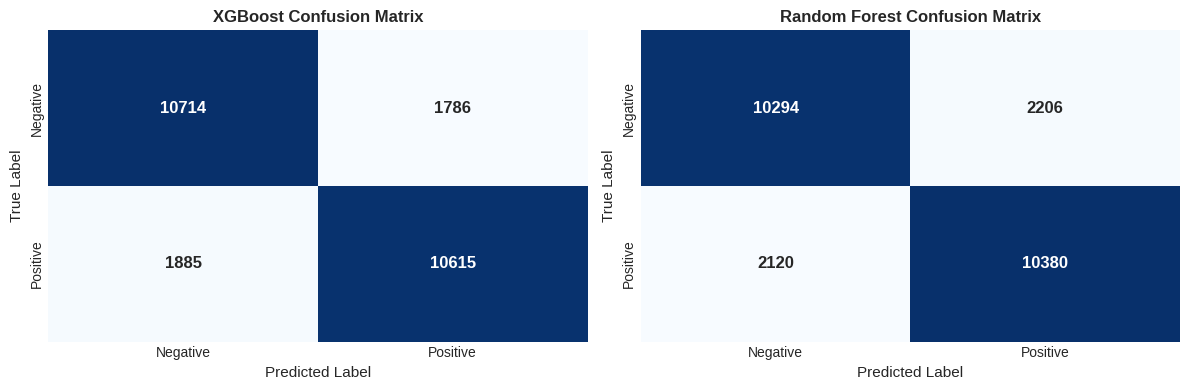

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

predictions = [
    ('XGBoost', xgb_preds),
    ('Random Forest', rf_preds)
]

for idx, (model_name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        cbar=False,
        annot_kws={'size': 12, 'weight': 'bold'}
    )
    axes[idx].set_title(f'{model_name} Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

In [14]:
print("\nDETAILED CLASSIFICATION REPORT - XGBoost")
print("="*75)
print(classification_report(
    y_test, xgb_preds,
    target_names=['Negative', 'Positive'],
    digits=4
))

print("\nDETAILED CLASSIFICATION REPORT - Random Forest")
print("="*75)
print(classification_report(
    y_test, rf_preds,
    target_names=['Negative', 'Positive'],
    digits=4
))


DETAILED CLASSIFICATION REPORT - XGBoost
              precision    recall  f1-score   support

    Negative     0.8504    0.8571    0.8537     12500
    Positive     0.8560    0.8492    0.8526     12500

    accuracy                         0.8532     25000
   macro avg     0.8532    0.8532    0.8532     25000
weighted avg     0.8532    0.8532    0.8532     25000


DETAILED CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

    Negative     0.8292    0.8235    0.8264     12500
    Positive     0.8247    0.8304    0.8276     12500

    accuracy                         0.8270     25000
   macro avg     0.8270    0.8270    0.8270     25000
weighted avg     0.8270    0.8270    0.8270     25000



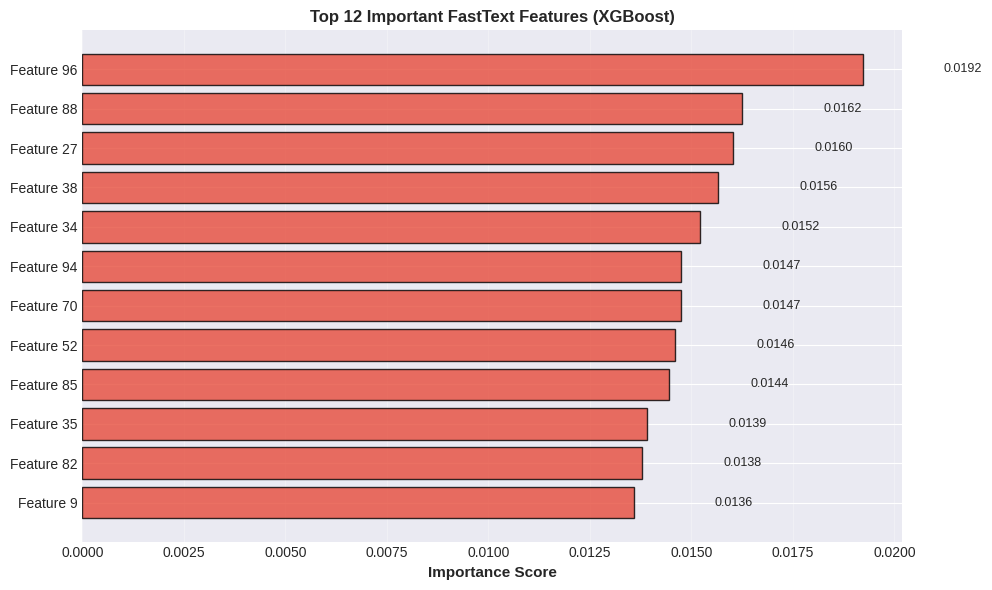

In [ ]:
importance_xgb = xgb_model.feature_importances_
importance_indices = np.argsort(importance_xgb)[-12:]

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(importance_indices)), importance_xgb[importance_indices], color='#e74c3c', alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(importance_indices)))
ax.set_yticklabels([f'Feature {i}' for i in importance_indices], fontsize=10)
ax.set_xlabel('Importance Score', fontsize=11, fontweight='bold')
ax.set_title('Top 12 Important FastText Features (XGBoost)', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(importance_xgb[importance_indices]):
    ax.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [21]:
print("\nFINAL SUMMARY")
print("="*75)
print(f"\nDataset: {len(df)} sentiment-labeled reviews")
print(f"Embeddings: FastText (100-dim, bigrams)")
print(f"Test set size: {len(y_test)} samples")

best_idx = results_df['Accuracy'].idxmax()
best_model = results_df.iloc[best_idx]['Model']
best_acc = results_df.iloc[best_idx]['Accuracy']

print(f"\nBest Model: {best_model}")
print(f"  Accuracy:  {best_acc:.4f}")
print(f"  Precision: {results_df.iloc[best_idx]['Precision']:.4f}")
print(f"  Recall:    {results_df.iloc[best_idx]['Recall']:.4f}")
print(f"  F1-Score:  {results_df.iloc[best_idx]['F1-Score']:.4f}")

print("\n" + "="*75)


FINAL SUMMARY

Dataset: 25000 sentiment-labeled reviews
Embeddings: FastText (100-dim, bigrams)
Test set size: 25000 samples

Best Model: XGBoost
  Accuracy:  0.8532
  Precision: 0.8560
  Recall:    0.8492
  F1-Score:  0.8526

